In [1]:
import copy
import spacy
from spacy.lang.en import English
import pandas as pd
import numpy as np
from nltk import stem
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata
import re
from nltk.tokenize import word_tokenize
from collections import Counter 
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import nltk
from sklearn import preprocessing #for label coding 0-ham; 1-spam
from sklearn.model_selection import KFold #for cv
from sklearn.feature_extraction.text import TfidfVectorizer #for TF-IDF vectorization

### Pre-Processing

In the pre-procssing step, we would like to filter out the not so useful data by achieving the following to prepare our texts:
<br>
- convert the texts into lower cases
- remove accented characters
- remove special characters (for example #, @ and more)
- remove stopwords
- remove punctuations
- lemmatize each word

#### remove accented characters

In order to remove accented characters, the texts are normalized using the compatibility decomposition known as the Normalization Form KD (NFKD). Since strings are stored as Unicode, each string in our texts is a sequence of code points as each character is represented by a code point. By encoding, the sequences of code points are converted into a set of bytes. In our case, we will encode the strings by both American Standard Code for Information Interchange (ascii) and UTF-8. 

#### remove special characters, stopwords and puncutations

To remove speical characters, we will strip the string and replace every character that is not a-z or A-Z.
<br>
<br>
The stopwords are the commonly used words (such as "the", "in", "an") that take up space in our database and take up processing time. We will removed the stopwords that are stored at "spacy.lang.en.English" from the texts.
<br>
<br>
In order to remove the punctuations, we will remove the characters from the texts that are not Unicode whitespace or Unicode word characters. 

#### lemmatization

When a word is lemmatized, it is returned to its root form. For example:
<br>
- words (lemmatizes to) word
- coding (lemmatizes to) code
- happily (lemmatizes to) happy

In [3]:
np.random.seed(123)

#get stopwords
stopwords = spacy.lang.en.stop_words.STOP_WORDS
#nlp = English()
#nlp = spacy.load("en") 
nlp = spacy.load('en_core_web_sm')

In [4]:
nlp

In [5]:
message = pd.read_csv('/Users/yunatan38/Documents/Projects/Natural Language Processing/SPAM text message 20170820 - Data.csv')

In [6]:
message.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# This class returns the pre-processed the data
class MessageProcessing:
    
    def __init__(self, df, col, remove_digits):
        self.df = df
        self.col = col
        
        self.count()
        self.normalization(remove_digits=remove_digits)
        self.lem()
    
    def count(self):
        df = copy.deepcopy(self.df)
        col = copy.deepcopy(self.col)
        #convert message into lower cases
        df[self.col]=df[col].apply(lambda row: " ".join(row.lower() for row in row.split()))
        #find word count
        df["word_count"]=df[col].apply(lambda row: len(str(row).split(" ")))
        #find numerics count
        df["numerics_count"]=df[col].apply(lambda row: len([row for row in row.split() if row.isdigit()]))
        #find stopwords count
        df["stopword_count"]=df[col].apply(lambda row: len([row for row in row.split() if row in stopwords]))
        
        self.df = copy.deepcopy(df)
        
    def normalization(self, remove_digits=True):
        #
        df = copy.deepcopy(self.df)
        col = copy.deepcopy(self.col)
        #remove accented characters
        df[col]=df[col].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
        
        # remove special characters such as # and @ and digits
        if remove_digits is True:
            pattern = r'[^a-zA-z\s]'
        else:
            pattern = r'[^a-zA-z0-9\s]'
        
        df[col] = df[col].str.replace(pattern, " ").str.strip()
        
        # removing stopwords
        df[col] = df[col].apply(lambda row: " ".join(row for row in row.split() if row not in stopwords))
        
        # remove punctuation
        df[col] = df[col].str.replace('[^\w\s]','')
        self.df = copy.deepcopy(df)
    
    
    def lem(self):
        df = copy.deepcopy(self.df)
        col = copy.deepcopy(self.col)
        
        #lemmatization
        df[col]=df[col].apply(lambda row: " ".join([x.lemma_ for x in nlp(row)]))
        #tokenization
        #df[col]= df[col].apply(lambda row: nlp(row))
        
        # using a stemmer
        #df[col] = " ".join([stemmer.stem(word) for word in df[col]])
        #lemmatization
        #df[col] = " ".join([lem.lemmatize(word) for word in df[col]])
        #df[col] = df[col].apply(lambda row: " ".join([df[col].lemma_ for w in nlp(row)]))
        self.df = copy.deepcopy(df)
        

In [8]:
msg = MessageProcessing(message, "Message", True).df

In [9]:
# First, we explore the ham texts
ham = msg.loc[message.Category == 'ham']
# combine the column of text messages into one raw text.
ham_msg=' '.join(ham.Message)

In [10]:
doc = nlp(ham_msg) 
  
# Token and Tag 
for token in doc: 
  print(token, token.pos_)

jurong NOUN
point NOUN
crazy ADJ
available ADJ
bugis NOUN
n CCONJ
great ADJ
world NOUN
la ADP
e NOUN
buffet NOUN
cine NOUN
get VERB
amore NOUN
wat NOUN
ok ADV
lar ADJ
joke NOUN
wif NOUN
u NOUN
oni X
u NOUN
dun DET
early ADJ
hor NOUN
u NOUN
c NOUN
nah INTJ
don VERB
t NOUN
think VERB
go VERB
usf ADJ
life NOUN
brother NOUN
like INTJ
speak VERB
treat VERB
like ADP
aid NOUN
patent NOUN
request NOUN
melle VERB
melle VERB
oru ADP
minnaminunginte NOUN
nurungu ADJ
vettam NOUN
set VERB
callertune NOUN
caller NOUN
press NOUN
copy NOUN
friend NOUN
callertune NOUN
m NOUN
go VERB
to ADP
home NOUN
soon ADV
don VERB
t NOUN
want VERB
talk NOUN
stuff NOUN
anymore ADV
tonight NOUN
k X
ve VERB
cry NOUN
today NOUN
ve VERB
search NOUN
right ADJ
word NOUN
thank VERB
breather NOUN
promise NOUN
will VERB
not ADV
help VERB
grant VERB
fulfil NOUN
promise NOUN
wonderful ADJ
blessing NOUN
time NOUN
date NOUN
sunday NOUN
oh INTJ
k NOUN
m NOUN
watch NOUN
eh INTJ
u PART
remember VERB
spell NOUN
yes INTJ
v ADP
naughty

home ADV
bathe VERB
sis NOUN
net NOUN
tell VERB
u X
finish VERB
k X
m NOUN
sorry ADJ
ve VERB
join VERB
league NOUN
people NOUN
do VERB
not ADV
touch VERB
mean VERB
great ADJ
deal NOUN
friend NOUN
time NOUN
great ADJ
personal ADJ
cost NOUN
great ADJ
week NOUN
hi INTJ
finally ADV
complete ADJ
course NOUN
stop VERB
suggest VERB
stay VERB
able ADJ
or CCONJ
stool NOUN
hope NOUN
ve VERB
settle VERB
new ADJ
school NOUN
year NOUN
wishin VERB
gr NOUN
day NOUN
gud DET
mrng NOUN
dear ADJ
hav NOUN
nice ADJ
day NOUN
u PRON
get VERB
person NOUN
story NOUN
hamster NOUN
dead ADJ
hey INTJ
tmr NOUN
meet NOUN
pm NOUN
orchard VERB
mrt NOUN
hi ADJ
kate NOUN
evening NOUN
hope NOUN
tomorrow NOUN
bit NOUN
bloody ADJ
babyjontet VERB
txt DET
u NOUN
xxx NOUN
find VERB
enc ADP
lt INTJ
gt X
send NOUN
lt PROPN
gt DET
buck NOUN
hello INTJ
darlin INTJ
-PRON- PUNCT
have VERB
finish NOUN
college NOUN
txt DET
u X
finish VERB
u PUNCT
love NOUN
kate NOUN
xxx NOUN
account NOUN
refill NOUN
successfully ADV
inr ADV
lt INTJ
d

sister NOUN
clear ADJ
round ADJ
birla ADJ
soft ADJ
yesterday NOUN
gudnite NOUN
tc NOUN
practice NOUN
go VERB
dis NOUN
yijue NOUN
ju PRON
see VERB
ur ADP
mail NOUN
case NOUN
huiming NOUN
have VERB
not ADV
send VERB
u NOUN
num NOUN
dis NOUN
num NOUN
small ADJ
prestige NOUN
problem NOUN
check NOUN
miss VERB
see VERB
jeremiah NOUN
great ADJ
month NOUN
nah INTJ
t NOUN
help NOUN
ve VERB
iphone ADJ
car NOUN
hour NOUN
half DET
m NOUN
go NOUN
apeshit ADJ
today NOUN
sorry ADJ
day NOUN
angry ADJ
misbehave NOUN
hurt NOUN
plz INTJ
plz INTJ
slap VERB
urself ADJ
bcoz NOUN
ur ADP
fault VERB
m NOUN
basically ADV
good ADJ
yo NOUN
guy NOUN
figure NOUN
need VERB
alcohol NOUN
jay NOUN
try NOUN
figure NOUN
safely ADV
spend VERB
weed NOUN
lt ADP
gt DET
ish ADJ
minute NOUN
minute NOUN
ago ADP
wtf NOUN
thank VERB
call NOUN
forget VERB
happy ADJ
onam NOUN
sirji ADV
fine ADV
remember VERB
meet NOUN
insurance NOUN
person NOUN
meet VERB
qatar ADJ
insha NOUN
allah ADP
rakhesh ADJ
ex NUM
tata NOUN
aig NOUN
join VERB

day NOUN
dear ADJ
sweet ADJ
heart NOUN
happy ADJ
birthday NOUN
dear ADJ
tirupur NOUN
da X
start NOUN
office NOUN
famous ADJ
quote NOUN
develop VERB
ability NOUN
listen VERB
unconditionally ADV
lose VERB
temper NOUN
self NOUN
confidence NOUN
mean VERB
marry NOUN
go VERB
college NOUN
pa ADJ
ill ADV
come VERB
self NOUN
pa ADP
oclock NOUN
bash NOUN
flat ADJ
plan NOUN
girl NOUN
stay VERB
bed NOUN
girl NOUN
doesn NOUN
t NOUN
need NOUN
recovery NOUN
time NOUN
-PRON- PUNCT
would VERB
pass VERB
have VERB
fun NOUN
coop NOUN
bed NOUN
special ADJ
know VERB
need VERB
hotel NOUN
get VERB
invitation NOUN
apologise NOUN
cali NOUN
sweet ADJ
come VERB
english PROPN
bloke VERB
s VERB
weddin NOUN
sorry ADV
take VERB
long ADV
omw NOUN
wait VERB
lt PROPN
gt DET
min NOUN
ok INTJ
minute NOUN
think VERB
btw ADV
alibi NOUN
cut NOUN
hair NOUN
time NOUN
imagine VERB
finally ADV
sink VERB
bath NOUN
pace NOUN
maybe ADV
have VERB
eat VERB
leave NOUN
imagine NOUN
feel VERB
cage NOUN
cock NOUN
surround VERB
bath NOUN


lor VERB
y PRON
u PART
ask VERB
ah INTJ
say VERB
u PUNCT
ask VERB
fri NOUN
say VERB
u PUNCT
ask VERB
today NOUN
alright INTJ
omw INTJ
get VERB
to PART
change VERB
order NOUN
half NOUN
th X
exactly ADV
anyways ADV
far ADJ
jide NOUN
study NOUN
visit NOUN
dunno VERB
y PRON
u PART
ask VERB
didn ADJ
t NOUN
spring NOUN
come VERB
early ADV
yay INTJ
lol ADV
win VERB
t PRON
feel VERB
bad ADJ
use NOUN
money NOUN
steak NOUN
dinner NOUN
d X
u PUNCT
do VERB
not ADV
trouble VERB
convincing ADJ
tel NOUN
twice ADJ
tel NOUN
neglect NOUN
msgs NOUN
do VERB
not ADV
c PUNCT
read VERB
do VERB
not ADV
reply VERB
leave VERB
qatar ADJ
tonite NOUN
search NOUN
opportunity NOUN
go VERB
fast ADV
pls INTJ
add VERB
ur ADP
prayer NOUN
dear ADJ
rakhesh ADJ
talk NOUN
thank VERB
look NOUN
appreciate VERB
wish NOUN
haha NOUN
mayb NOUN
u PUNCT
rite NOUN
u PRON
know VERB
da PROPN
feeling NOUN
like ADP
gd NOUN
lor VERB
u PRON
faster ADV
find VERB
gal ADJ
group NOUN
attach VERB
liao ADV
yes INTJ
glad ADJ
little ADJ
time NOUN

magicalsong NOUN
blogspot NOUN
com NOUN
k X
wait VERB
chikku NOUN
il PROPN
send VERB
aftr NOUN
lt PROPN
gt DET
min NOUN
m VERB
diet NOUN
eat ADJ
slice NOUN
pizza NOUN
yesterday NOUN
ugh ADV
m PUNCT
diet NOUN
k X
kvb ADJ
acc NOUN
detail NOUN
oh INTJ
come VERB
ah INTJ
m VERB
sorry ADJ
win NOUN
t NOUN
b NOUN
able ADJ
friday NOUN
hope VERB
u PART
find VERB
alternative ADJ
hope NOUN
yr ADP
term NOUN
s PRON
go VERB
ok ADJ
congratulation NOUN
ore NOUN
mo ADP
owo PRON
wa PART
enjoy VERB
wish NOUN
happy ADJ
moment NOUN
fro ADJ
samus NOUN
shoulder NOUN
time NOUN
think VERB
will VERB
need VERB
know VERB
near ADP
campus NOUN
dun X
wear NOUN
jean NOUN
lor NOUN
fever NOUN
vomitin NOUN
k X
k X
college NOUN
good ADJ
friday NOUN
stuff NOUN
like ADP
pig NOUN
yesterday NOUN
feel VERB
bleh NOUN
writhe DET
pain NOUN
kind NOUN
bleh NOUN
sell VERB
will VERB
ton VERB
coin NOUN
sell NOUN
coin NOUN
paypal ADJ
voila NOUN
money NOUN
life NOUN
pocket NOUN
-PRON- NOUN
be VERB
lot NOUN
place NOUN
hospital NOUN
medic

jean NOUN
thk NOUN
c NOUN
u X
aiyah VERB
sorry ADJ
lor NOUN
watch NOUN
tv NOUN
watch NOUN
forget VERB
check NOUN
phone NOUN
hen NOUN
night NOUN
go VERB
swing VERB
good ADJ
afternoon NOUN
love NOUN
go VERB
day NOUN
wake VERB
early ADJ
online ADJ
wait VERB
hmmm ADJ
italian ADJ
boy NOUN
online ADJ
grin NOUN
smoke NOUN
time NOUN
ve VERB
smoke NOUN
week NOUN
call NOUN
text NOUN
want VERB
smoke NOUN
will VERB
headache VERB
try VERB
figure NOUN
u PUNCT
trust NOUN
math NOUN
promise NOUN
o PRON
s VERB
s PART
time NOUN
dhoni NOUN
rock NOUN
ok INTJ
ill ADV
tell VERB
company NOUN
awesome ADJ
think VERB
th DET
usf ADJ
time NOUN
tonight NOUN
mean VERB
think VERB
teju NOUN
m VERB
good ADJ
movie NOUN
ok INTJ
leave VERB
hourish NOUN
kallis NOUN
home NOUN
ground NOUN
amla NOUN
home NOUN
town NOUN
durban NOUN
let VERB
saturday NOUN
monday NOUN
convenience NOUN
hey INTJ
time NOUN
drive VERB
fri NOUN
evaluation NOUN
fri NOUN
m NOUN
go VERB
lunch NOUN
wif NOUN
family NOUN
aft NOUN
dat NOUN
str NOUN
orchard 

fran NOUN
decide VERB
n CCONJ
e PUNCT
way NOUN
-PRON- PROPN
be VERB
completely ADV
broke VERB
knacker NOUN
get VERB
bout ADP
c NOUN
u X
mrw NOUN
love VERB
janx DET
p NOUN
s PART
dad NOUN
fone NOUN
credit NOUN
can VERB
not ADV
pick VERB
phone NOUN
right NOUN
pls INTJ
send VERB
message NOUN
right ADV
will VERB
appointment VERB
right ADJ
designation NOUN
software NOUN
developer NOUN
chennai NOUN
jokin VERB
oni ADP
lar NOUN
u NOUN
busy ADJ
wun VERB
disturb VERB
u PRON
ok INTJ
careful ADJ
don X
t NOUN
text NOUN
drive NOUN
will VERB
spirit VERB
will VERB
bb VERB
soon ADV
try VERB
sure ADJ
need VERB
u PART
r VERB
close ADJ
heart NOUN
u NOUN
away ADV
shattered ADJ
plz INTJ
stay VERB
love NOUN
u ADP
babe NOUN
r NOUN
u NOUN
sure ADJ
alrite ADJ
idiot NOUN
txt DET
bak NOUN
girlie NOUN
abt NOUN
make VERB
pic ADJ
big ADJ
get NOUN
get VERB
colour ADJ
lor NOUN
colour NOUN
light NOUN
n CCONJ
e DET
dark ADJ
lor NOUN
actually ADV
m VERB
s NOUN
styling VERB
hair NOUN
whenevr NOUN
ur ADP
sad ADJ
whenevr NO

yr NOUN
project NOUN
say VERB
welp NOUN
m VERB
guy NOUN
browsin NOUN
compulsory NOUN
ok ADP
purity NOUN
friendship NOUN
smile NOUN
reading VERB
forward ADJ
message NOUN
smile NOUN
see VERB
gud NOUN
evng VERB
musthu NOUN
sorry ADJ
will VERB
later ADV
add VERB
don NOUN
t NOUN
care NOUN
t PUNCT
dude NOUN
fuck NOUN
hey INTJ
money NOUN
want VERB
hello INTJ
lover NOUN
go VERB
new ADJ
job NOUN
happy ADJ
think NOUN
wake VERB
slave NOUN
send VERB
tease NOUN
kiss NOUN
sea NOUN
tell VERB
number NOUN
gautham NOUN
tell VERB
need NOUN
investigate NOUN
ok INTJ
juz NOUN
receive NOUN
can VERB
not ADV
believe VERB
say VERB
thing NOUN
morning NOUN
want VERB
good ADJ
morning NOUN
love NOUN
beautiful ADJ
morning NOUN
library NOUN
later ADV
end NOUN
vomit NOUN
okay INTJ
come VERB
money NOUN
money NOUN
be VERB
not ADV
thing NOUN
sha VERB
weather VERB
extra ADJ
warm ADJ
cold NOUN
pls INTJ
lot NOUN
vitamin NOUN
c NOUN
hey INTJ
gal NOUN
u PUNCT
go VERB
e NOUN
drive NOUN
centre NOUN
tmr NOUN
m NOUN
yahoo NOUN
me

heart NOUN
put VERB
constant ADJ
smile NOUN
face NOUN
make VERB
feel NOUN
love NOUN
care NOUN
shit NOUN
wasn ADV
t NOUN
surprise NOUN
go VERB
spend VERB
evening NOUN
french ADJ
guy NOUN
meet VERB
town NOUN
fool NOUN
bit VERB
didn ADJ
t NOUN
let VERB
fuck ADJ
great ADJ
comedy NOUN
can VERB
not ADV
stop VERB
laugh NOUN
da PROPN
alright ADV
set NOUN
text NOUN
man NOUN
hi INTJ
keen ADJ
kind NOUN
feel VERB
shouldn NOUN
t NOUN
tomo NOUN
don X
t DET
mind NOUN
sleep NOUN
nt ADV
feeling VERB
u X
switch VERB
fone NOUN
dammit VERB
india ADJ
lead NOUN
will VERB
post VERB
l NOUN
r NOUN
class NOUN
tht NOUN
wat NOUN
wright NOUN
brother NOUN
fly VERB
evening NOUN
v ADP
good ADJ
somewhat ADV
event NOUN
laden ADJ
fill NOUN
don NOUN
t NOUN
worry NOUN
head NOUN
ok INTJ
throat NOUN
wreck NOUN
u PRON
laugh VERB
loud ADJ
u NOUN
talk NOUN
spontaneously ADV
u PRON
do VERB
not ADV
care VERB
feel VERB
u PUNCT
probably ADV
dear ADJ
amp NOUN
good ADJ
friend NOUN
goodeven VERB
dear ADJ
laptop NOUN
do VERB
not ADV
f

u NOUN
dun NOUN
wan NOUN
y PRON
u NOUN
dun NOUN
like INTJ
ah INTJ
wat VERB
u NOUN
eating VERB
send NOUN
ur ADP
email NOUN
-PRON- PUNCT
would VERB
soon ADV
wat VERB
make VERB
people NOUN
dearer NOUN
de X
happiness NOUN
dat NOUN
u PRON
feel VERB
u PART
meet VERB
de X
pain NOUN
u X
feel VERB
u PART
miss VERB
dem NOUN
dude NOUN
s NOUN
teresa ADJ
hope NOUN
okay INTJ
do VERB
not ADV
hear VERB
people NOUN
call VERB
receive VERB
package NOUN
dec NOUN
lt PROPN
gt NOUN
thot NOUN
ld ADV
like INTJ
know VERB
fantastic ADJ
year NOUN
good ADJ
reading NOUN
plus CCONJ
bam VERB
aid VERB
usmle ADJ
work NOUN
hey INTJ
gorgeous ADJ
man NOUN
work VERB
mobile ADJ
number NOUN
good ADJ
babe NOUN
squishy NOUN
mwah NOUN
later ADV
pls INTJ
s VERB
way NOUN
stay VERB
oh INTJ
hello INTJ
thanx NOUN
take VERB
get VERB
job NOUN
start NOUN
monday NOUN
time NOUN
ur ADP
flight NOUN
tmr NOUN
come VERB
prominent ADJ
bite NOUN
mark NOUN
right ADJ
cheek NOUN
september NOUN
wet ADJ
right NOUN
s VERB
husband NOUN
norm NOUN
tomor

way ADV
m NOUN
tired ADJ
have VERB
thia VERB
argument NOUN
week NOUN
lt ADP
gt DET
movie NOUN
do VERB
not ADV
inlude VERB
preview NOUN
get VERB
beautiful ADJ
truth NOUN
gravity NOUN
read VERB
carefully ADV
heart NOUN
feel VERB
light ADJ
feel VERB
heavy ADJ
leaf NOUN
goodmorn NOUN
ambrith ADP
madurai NOUN
meet NOUN
u PUNCT
arun ADJ
dha NOUN
marrge NOUN
remembr NOUN
read VERB
shame NOUN
tell VERB
take NOUN
run NOUN
blame NOUN
u PUNCT
long ADJ
time NOUN
princess NOUN
kitty NOUN
shave VERB
natural ADJ
good ADJ
bb NOUN
will VERB
not ADV
use VERB
wife NOUN
doctor NOUN
ya PRON
come VERB
ago ADV
tomorrow NOUN
onwards ADV
eve VERB
work NOUN
lor NOUN
toa NOUN
payoh NOUN
get VERB
place NOUN
walk NOUN
meh NOUN
don NOUN
t NOUN
anybody NOUN
s VERB
number NOUN
haven NOUN
t NOUN
think VERB
tactful ADJ
way NOUN
ask VERB
alex ADJ
movie NOUN
theatre NOUN
watch VERB
unlimited ADJ
movie NOUN
pay NOUN
u PRON
have VERB
lunch NOUN
bore NOUN
yes INTJ
obviously ADV
egg NOUN
pert NOUN
potato NOUN
head NOUN
speak

plaid ADJ
album NOUN
gd NOUN
new ADJ
air NOUN
hilarious ADJ
boughtbraindancea NOUN
comp VERB
ofstuff ADV
aphexs VERB
abel NOUN
u NOUN
hav NOUN
hear VERB
c NOUN
u NOUN
sn X
xxxx NOUN
pls INTJ
tell VERB
nelson NOUN
bb NOUN
s PART
long ADJ
comin NOUN
money NOUN
expect VERB
be VERB
not ADV
come VERB
drink NOUN
take VERB
doesn NOUN
t NOUN
vomit NOUN
temp NOUN
drop NOUN
unmit VERB
let VERB
know VERB
think VERB
send VERB
text NOUN
home NOUN
phone NOUN
can VERB
not ADV
display VERB
text NOUN
want VERB
send VERB
number NOUN
day NOUN
use NOUN
sleep NOUN
lt PROPN
gt ADP
k NOUN
will VERB
m VERB
close ADJ
u PUNCT
buy NOUN
newspaper NOUN
nope NOUN
wif NOUN
sis NOUN
lor NOUN
aft NOUN
bathing NOUN
dog NOUN
bathe VERB
look VERB
like ADP
s PRON
go VERB
rain NOUN
soon ADV
boo VERB
m VERB
way NOUN
mom NOUN
s VERB
make VERB
tortilla NOUN
soup NOUN
yummmm ADJ
management NOUN
puzzel NOUN
find VERB
way NOUN
didn ADJ
t NOUN
include VERB
detail NOUN
like ADP
spoil NOUN
get VERB
threat NOUN
sale NOUN
executive A

ya PRON
remember VERB
da PROPN
btw ADV
try VERB
th X
guy NOUN
commit VERB
random ADJ
dude NOUN
busy ADJ
juz NOUN
dun NOUN
wan NOUN
early ADV
hee NOUN
rightio NOUN
be VERB
not ADV
bright ADJ
early ADJ
morning NOUN
great ADJ
m NOUN
church NOUN
holla NOUN
brum NOUN
thank VERB
put VERB
keep VERB
happy ADJ
soon ADV
donno VERB
scorable ADJ
lt INTJ
gt DET
great ADJ
loxahatchee NOUN
xma NOUN
tree NOUN
burn VERB
update NOUN
totally ADV
star NOUN
yes INTJ
do VERB
not ADV
care VERB
need VERB
bad ADJ
princess NOUN
guy NOUN
kadeem NOUN
hasn NOUN
t NOUN
selling NOUN
break NOUN
know VERB
guy NOUN
s PRON
paranoid VERB
fuck NOUN
doesn NOUN
t NOUN
like INTJ
sell VERB
t NOUN
til ADV
late ADJ
tonight NOUN
sorry INTJ
will VERB
later ADV
tmr VERB
u NOUN
brin DET
lar ADJ
aiya NOUN
later ADV
come VERB
n CCONJ
c NOUN
lar ADJ
mayb NOUN
u PART
neva ADJ
set VERB
properly ADV
u PRON
get VERB
da PROPN
help NOUN
sheet NOUN
wif NOUN
u NOUN
u NOUN
knw NOUN
dis NOUN
lt INTJ
gt NOUN
dun X
believe VERB
wat VERB
k X
thank

dinner NOUN
s NOUN
da PROPN
al PROPN
r PROPN
lt PROPN
gt DET
unni NOUN
thank VERB
dear ADJ
recharge NOUN
rakhesh ADJ
know VERB
m NOUN
lack NOUN
particular ADJ
dramastorm NOUN
s VERB
detail NOUN
m NOUN
worried ADJ
haha NOUN
can VERB
not ADV
tmr VERB
forfeit ADJ
haha INTJ
hey INTJ
glad ADJ
u PRON
r NOUN
good ADJ
hear NOUN
u PART
treat VERB
urself PRON
digi NOUN
cam VERB
good ADJ
r NOUN
pm NOUN
fab ADJ
new ADJ
year NOUN
c NOUN
u X
coupla NOUN
wks NOUN
way ADV
m NUM
go VERB
cal ADJ
sir NOUN
meeting NOUN
s PART
love NOUN
hear VERB
v PUNCT
sundayish ADJ
sorry INTJ
da INTJ
thangam NOUN
sorry INTJ
hold VERB
prasad ADJ
tiwary ADJ
rcb NOUN
battle NOUN
bang NOUN
kochi NOUN
thank VERB
god NOUN
bed NOUN
don X
t NOUN
cancer NOUN
mom NOUN
make VERB
big ADJ
deal NOUN
regular ADJ
checkup NOUN
aka ADV
pap VERB
smear NOUN
gobi NOUN
art NOUN
college NOUN
want VERB
talk NOUN
pandy ADJ
join NOUN
w DET
technology NOUN
today NOUN
get VERB
job NOUN
try NOUN
lose ADJ
fact NOUN
tee NOUN
hee NOUN
hi INTJ
speak VE

misscall NOUN
amp NOUN
send VERB
ur INTJ
frndz NOUN
amp NOUN
miss VERB
call NOUN
u NOUN
u PART
miss VERB
u PUNCT
marry NOUN
ur ADP
lover NOUN
class NOUN
hour NOUN
sorry INTJ
wat VERB
time NOUN
u X
finish NOUN
ur ADP
lect NOUN
today NOUN
sad ADJ
story NOUN
man NOUN
week NOUN
b NOUN
day NOUN
wife NOUN
nt ADV
wish VERB
parent NOUN
forget VERB
n CCONJ
kid NOUN
go VERB
work NOUN
colleague NOUN
wish NOUN
enter VERB
cabin NOUN
pa CCONJ
say VERB
happy ADJ
b NOUN
day NOUN
boss NOUN
feel VERB
special ADJ
askd NOUN
lunch NOUN
lunch NOUN
invite NOUN
apartment NOUN
go VERB
say VERB
u PUNCT
mind NOUN
bedroom NOUN
minute NOUN
ok INTJ
sed ADJ
sexy ADJ
mood NOUN
come VERB
minut NOUN
latr NOUN
wid VERB
cake NOUN
n CCONJ
wife NOUN
parent NOUN
kidz NOUN
friend NOUN
n CCONJ
colleague NOUN
scream NOUN
surprise NOUN
wait VERB
sofa NOUN
naked ADJ
s PART
fine ADJ
good ADJ
hear VERB
dear ADJ
happy ADJ
new ADJ
year NOUN
oh INTJ
go VERB
wipro ADJ
interview NOUN
today NOUN
tall ADJ
princess NOUN
doubt NOUN
handle 

sorry INTJ
telling NOUN
pls INTJ
send VERB
correct ADJ
da X
happen VERB
yo ADP
date NOUN
webpage NOUN
s VERB
available ADJ
wake NOUN
yeesh NOUN
late ADJ
didn ADJ
t NOUN
fall NOUN
asleep ADV
til ADV
lt INTJ
gt DET
dear ADJ
know VERB
lt INTJ
gt X
th X
lt INTJ
gt X
th X
birthday NOUN
love NOUN
gopalettan NOUN
plan NOUN
small ADJ
gift NOUN
day NOUN
like INTJ
participate VERB
welcome ADJ
contact NOUN
admin NOUN
team NOUN
detail NOUN
k X
k X
tomorrow NOUN
onwards ADV
start VERB
ah INTJ
u NOUN
talk VERB
bout VERB
early ADJ
morning NOUN
s VERB
noon NOUN
fine ADJ
remember VERB
ok INTJ
buy VERB
sound ADJ
good ADJ
post NOUN
ok ADP
april NOUN
can VERB
not ADV
wait VERB
boy NOUN
good ADJ
yo INTJ
ass NOUN
quick ADJ
ay INTJ
wana NOUN
meet VERB
sit NOUN
u ADP
wkg NOUN
sit VERB
m PART
wait VERB
till ADP
bus NOUN
pick NOUN
apart ADV
tell VERB
yesterday NOUN
ok INTJ
lor NOUN
buy VERB
wat ADJ
somebody NOUN
andro NOUN
steal VERB
ice NOUN
don NOUN
know VERB
t NOUN
msg NOUN
recently ADV
shop NOUN
mark NOUN
d

way NOUN
moon NOUN
come VERB
color ADJ
dream NOUN
star NOUN
musical ADJ
sm ADP
warm ADJ
peaceful ADJ
sleep NOUN
good ADJ
night NOUN
finish NOUN
eat VERB
get VERB
u NOUN
plate NOUN
leftover VERB
time NOUN
thanx NOUN
lot NOUN
hurry VERB
home ADV
u NUM
big ADJ
butt NOUN
hang VERB
caller NOUN
u NUM
food NOUN
m NOUN
starve VERB
don NOUN
t NOUN
ask VERB
cook NOUN
lol INTJ
right ADV
diet NOUN
everyday ADV
cheat NOUN
m NOUN
mean VERB
fatty ADV
great ADJ
day NOUN
beautiful ADJ
happen VERB
interview NOUN
solve NOUN
d X
case NOUN
man NOUN
find VERB
murder NOUN
lt ADP
decimal ADJ
gt NOUN
lt PROPN
gt DET
afternoon NOUN
wife NOUN
call VERB
police NOUN
police NOUN
question NOUN
wife NOUN
sir NOUN
sleep NOUN
murder NOUN
take VERB
place NOUN
cook NOUN
cook VERB
gardener NOUN
pick NOUN
vegetable NOUN
house NOUN
maid NOUN
go VERB
d X
post VERB
office NOUN
child NOUN
go VERB
play VERB
neighbour NOUN
go VERB
marriage NOUN
police NOUN
arrest NOUN
d X
murderer NOUN
immediately ADV
s PART
reply VERB
reason NO

den VERB
hop NOUN
parco NOUN
nb NOUN
sun NOUN
cine NOUN
frm NOUN
den VERB
hop NOUN
orc VERB
mrt ADJ
hip NOUN
hop NOUN
seek VERB
lady NOUN
street NOUN
freak NOUN
sheet NOUN
phone NOUN
haha NOUN
figure NOUN
find VERB
piece NOUN
priscilla NOUN
s PART
bowl NOUN
actually ADV
fuck ADJ
find ADJ
excuse NOUN
tampa NOUN
point NOUN
january NOUN
yay NOUN
finally ADV
lol ADV
miss VERB
cinema NOUN
trip NOUN
week NOUN
day NOUN
work NOUN
day NOUN
saturday NOUN
sunday NOUN
aathi NOUN
dear ADJ
heart NOUN
love NOUN
mind NOUN
wisdom NOUN
eye NOUN
r NOUN
dream NOUN
amp NOUN
life NOUN
frnd NOUN
alwys NOUN
touch NOUN
good ADJ
night NOUN
amp NOUN
sweet ADJ
dream NOUN
think VERB
-PRON- PUNCT
be VERB
wait VERB
bus NOUN
inform NOUN
get VERB
time NOUN
soon ADV
s PART
thing NOUN
quick ADJ
question NOUN
night NOUN
end NOUN
day NOUN
morning NOUN
come VERB
special ADJ
way NOUN
smile NOUN
like ADP
sunny ADJ
ray NOUN
leave VERB
worry NOUN
blue ADJ
blue ADJ
bay NOUN
gud NOUN
mrng NOUN
probably ADV
come VERB
everybody NO

play NOUN
football NOUN
basketball NOUN
outdoors ADV
ask VERB
macho ADJ
price NOUN
range NOUN
want VERB
new ADJ
plus CCONJ
interfued ADJ
blackberry NOUN
bold ADJ
lt PROPN
gt X
bb X
sorry INTJ
send VERB
blank ADJ
msg NOUN
yup INTJ
try VERB
study NOUN
hey INTJ
check VERB
da X
list NOUN
da X
mean ADJ
apology NOUN
text NOUN
drug NOUN
lt ADP
gt DET
night NOUN
mean VERB
february ADJ
april NOUN
will VERB
get VERB
place NOUN
stay NOUN
don NOUN
t NOUN
hustle NOUN
forth ADV
audition NOUN
season NOUN
sister NOUN
move VERB
away ADV
harlem NOUN
go VERB
workout NOUN
lor NOUN
muz VERB
lose VERB
e NOUN
fat ADJ
damn ADJ
poor ADJ
zac NOUN
doesn NOUN
t NOUN
stand VERB
chance NOUN
message NOUN
responce ADJ
happend NOUN
want VERB
tel NOUN
u NUM
thing NOUN
u NUM
mistake NOUN
k DET
message NOUN
send VERB
yeah INTJ
right INTJ
will VERB
bring VERB
tape NOUN
measure VERB
fri ADJ
chance NOUN
search NOUN
hard ADV
let VERB
try VERB
meet VERB
u PUNCT
work NOUN
tel NOUN
shall VERB
work VERB
tomorrow NOUN
head NOUN
s

money NOUN
buy VERB
bunch NOUN
lotto NOUN
ticket NOUN
win NOUN
lt ADP
gt NOUN
u X
lt PROPN
gt ADJ
deal NOUN
ok INTJ
askd INTJ
u NOUN
question NOUN
hour NOUN
answer NOUN
watch NOUN
tv NOUN
lor NOUN
nice ADJ
like ADP
lor NOUN
m NOUN
think VERB
chennai NOUN
forget VERB
come VERB
auction NOUN
u PART
come VERB
n CCONJ
pick VERB
ar ADP
early ADJ
bird NOUN
purchase NOUN
go VERB
pay VERB
rent NOUN
bank NOUN
authorise NOUN
payment NOUN
erm ADV
ill ADJ
pick NOUN
pm NOUN
will VERB
time NOUN
park VERB
hey INTJ
mate VERB
how ADV
s NOUN
u X
honey NOUN
u PART
ave VERB
good ADJ
holiday NOUN
gimmi NOUN
de X
goss VERB
x PUNCT
howz NOUN
pain NOUN
come VERB
today NOUN
say VERB
ystrday ADJ
ice NOUN
medicine NOUN
chile NOUN
s VERB
lt INTJ
decimal ADJ
gt ADJ
hour NOUN
drive NOUN
come VERB
time NOUN
sublet ADJ
feb NOUN
april NOUN
audition NOUN
season NOUN
yes INTJ
ammae VERB
life NOUN
take VERB
lot NOUN
turn NOUN
sit VERB
try VERB
hold VERB
steering NOUN
yeah INTJ
s PRON
think VERB
lemme NOUN
know VERB
s PRON

school NOUN
thing NOUN
important ADJ
ha INTJ
ha INTJ
nan INTJ
yalrigu VERB
heltini NOUN
iyo ADP
kothi NOUN
chikku NOUN
u PART
share NOUN
thing NOUN
wit VERB
far ADV
didn ADJ
t NOUN
tell VERB
body NOUN
utter ADJ
word NOUN
abt NOUN
u X
ur X
trust NOUN
tell VERB
plz INTJ
nxt NUM
time NOUN
do VERB
not ADV
use VERB
word NOUN
ok INTJ
chikku NOUN
b PUNCT
noice VERB
text NOUN
hi INTJ
di X
yijue NOUN
meeting NOUN
pm NOUN
esaplanade NOUN
tonight NOUN
aight NOUN
ve VERB
set VERB
free ADJ
think NOUN
text NOUN
blake NOUN
s PART
address NOUN
occur VERB
m NOUN
sure ADJ
m NOUN
think VERB
hi INTJ
dear INTJ
see VERB
dear ADJ
happy ADJ
battery NOUN
low ADJ
age NOUN
s VERB
abj NOUN
prof NOUN
pass VERB
paper NOUN
sem NOUN
congrat NOUN
student NOUN
enna VERB
kalaachutaarama ADJ
prof NOUN
gud DET
mrng NOUN
do VERB
not ADV
kick VERB
coco NOUN
s PUNCT
fyi VERB
m PRON
go VERB
to PART
sporadically ADV
start VERB
like ADP
lt INTJ
gt DET
bc NOUN
do VERB
shit NOUN
hope VERB
-PRON- PUNCT
be VERB
have VERB
fun NOUN
u

leaf NOUN
nothing NOUN
relation NOUN
gud DET
eveb NOUN
u NOUN
science NOUN
tell NOUN
chocolate NOUN
melt NOUN
sunlight NOUN
don X
t NOUN
walk NOUN
sunlight NOUN
bcoz NOUN
don X
t NOUN
want VERB
loss NOUN
sweet ADJ
friend NOUN
yes INTJ
come VERB
nyc ADJ
audiition NOUN
try VERB
relocate NOUN
pock NOUN
congrat NOUN
s PART
great ADV
wanted VERB
tell VERB
tell ADJ
score NOUN
cos ADP
relax VERB
motivate ADJ
thank VERB
share NOUN
wud ADV
mind NOUN
u PRON
do VERB
not ADV
miss VERB
u PRON
do VERB
not ADV
need VERB
u X
wil VERB
hurt VERB
wen PROPN
u PRON
need VERB
amp NOUN
u PRON
do VERB
not ADV
tell VERB
care NOUN
hey INTJ
mr NOUN
what NOUN
s VERB
bill NOUN
brison NOUN
book NOUN
language NOUN
word NOUN
okay INTJ
good ADJ
problem NOUN
thanx NOUN
information NOUN
ikea NOUN
spell VERB
cap NOUN
yell NOUN
thought VERB
leave NOUN
sit NOUN
bed NOUN
mess NOUN
come VERB
say VERB
go VERB
get VERB
home NOUN
class NOUN
don NOUN
t NOUN
try NOUN
bullshit NOUN
make NOUN
want VERB
listen VERB
u X
g NOUN
w X
r 

ttyl ADJ
will VERB
pick VERB
pm NOUN
taunton NOUN
want VERB
come VERB
oh INTJ
outside ADJ
player NOUN
allow VERB
play NOUN
know VERB
lor NOUN
erutupalam NOUN
thandiyachu NOUN
y PRON
can VERB
not ADV
u PRON
try VERB
new ADJ
invention NOUN
fly VERB
m NOUN
joke NOUN
ful ADJ
song NOUN
lyric NOUN
u PART
reckon VERB
need NOUN
arrange ADJ
transport NOUN
u NOUN
t NOUN
thank VERB
true ADJ
lov NOUN
n CCONJ
care NOUN
wil NOUN
nevr NOUN
unrecogniz ADV
somone NOUN
make VERB
mistake NOUN
value NOUN
definitly ADV
undrstnd ADJ
start NOUN
miss VERB
shop NOUN
eh INTJ
ger VERB
tok NOUN
abt NOUN
syd NOUN
leh INTJ
haha INTJ
stand VERB
good ADJ
weekend NOUN
miss VERB
miss ADJ
khelate NOUN
kintu NOUN
opponenter NOUN
miss VERB
dhorte NOUN
lage NOUN
that ADJ
s VERB
d VERB
rule VERB
great ADJ
phone NOUN
receiving NOUN
quality NOUN
win NOUN
chance NOUN
plz INTJ
lt ADP
new ADJ
deus ADJ
ex NUM
game NOUN
comin NOUN
early ADJ
yr NOUN
computer NOUN
fry NOUN
essential ADJ
don NOUN
t NOUN
spare ADJ
fuck ADJ
idiot NOUN


town NOUN
haha INTJ
yeah INTJ
oz INTJ
kind NOUN
shitload NOUN
ok ADV
u NOUN
shopping VERB
u X
pay NOUN
d NOUN
life NOUN
mean VERB
lot NOUN
love NOUN
life NOUN
love VERB
people NOUN
life NOUN
world NOUN
call VERB
friend NOUN
world NOUN
ge VERB
alright INTJ
will VERB
bring VERB
like INTJ
lt INTJ
gt DET
min NOUN
pls INTJ
do VERB
not ADV
play VERB
life NOUN
eatin NOUN
lunch NOUN
hmmm NOUN
day NOUN
didn NOUN
t NOUN
try VERB
g PUNCT
decide VERB
head NOUN
ok INTJ
prob NOUN
surly ADV
ill ADV
come VERB
review NOUN
march NOUN
end NOUN
ready ADJ
sure ADJ
problem NOUN
capital NOUN
complete ADJ
far ADV
s VERB
work NOUN
lady NOUN
tessy VERB
pls INTJ
favor VERB
pls INTJ
convey VERB
birthday NOUN
wish VERB
nimya NOUN
pls INTJ
dnt VERB
forget VERB
today NOUN
birthday NOUN
shijas NOUN
pls INTJ
food NOUN
preferably ADV
pap VERB
slowly ADV
load NOUN
sugar NOUN
hour NOUN
water NOUN
slowly ADV
guy NOUN
get VERB
dumb ADJ
realize VERB
okey ADP
dokey NOUN
ill ADJ
bit NOUN
sort NOUN
stuff NOUN
don X
da PROPN
wh

tell VERB
u X
effect NOUN
birth NOUN
control NOUN
massive ADJ
gut NOUN
wrenching NOUN
cramp NOUN
month NOUN
didn NOUN
t NOUN
sleep NOUN
night NOUN
send VERB
new ADJ
number NOUN
convey NOUN
regard NOUN
half ADJ
year NOUN
miss VERB
friendship NOUN
can VERB
not ADV
pick VERB
phone NOUN
right NOUN
pls INTJ
send VERB
message NOUN
oh INTJ
fuck NOUN
s VERB
sake NOUN
s PRON
like INTJ
tallahassee ADJ
haha NOUN
person NOUN
go VERB
to PART
ask VERB
taka NOUN
lor VERB
wat VERB
time NOUN
u NOUN
wan NOUN
come VERB
n CCONJ
look VERB
m NOUN
reach VERB
stop VERB
didn ADJ
t NOUN
mean ADJ
post NOUN
write VERB
like ADP
time NOUN
ve VERB
ritten VERB
stuff NOUN
let VERB
sit VERB
feeling NOUN
time NOUN
angry ADJ
leave NOUN
hit VERB
send NOUN
stop NOUN
wasn ADV
t X
check VERB
phone NOUN
get NOUN
car NOUN
wasn NOUN
t NOUN
say VERB
didn ADJ
t NOUN
sleep NOUN
bored ADJ
wouldn NOUN
t NOUN
time NOUN
clean ADJ
fold NOUN
laundry ADJ
etc X
bed NOUN
come VERB
online ADV
today NOUN
night NOUN
special ADJ
m NOUN
solihul

stuff NOUN
sing NOUN
st NOUN
andre ADP
virgil NOUN
s PART
cream NOUN
check NOUN
room NOUN
befor ADP
activity NOUN
fri NOUN
ah INTJ
okie NOUN
lor NOUN
go VERB
drivin NOUN
den VERB
shoppin NOUN
tt ADP
gokila NOUN
talk VERB
aha INTJ
hi INTJ
shanil NOUN
rakhesh ADJ
thank VERB
exchange NOUN
uncut ADJ
diamond NOUN
stuff NOUN
leave VERB
excellent ADJ
service NOUN
dino NOUN
prem VERB
k X
k X
month NOUN
kote NOUN
birthday NOUN
know VERB
m VERB
broke ADJ
oh INTJ
small ADJ
lt INTJ
gt ADP
sorry ADJ
mate NOUN
phone NOUN
do VERB
not ADV
write VERB
love NOUN
kate NOUN
ah INTJ
confuse NOUN
thing NOUN
do VERB
not ADV
think VERB
friend NOUN
maybe ADV
wrong ADJ
thing NOUN
sort ADV
invite VERB
tho PRON
come VERB
cos ADP
money NOUN
aight ADV
close ADV
nope NOUN
that ADJ
s VERB
fine ADJ
nap NOUN
tho NOUN
news NOUN
hassle NOUN
weed NOUN
week NOUN
andr NOUN
money NOUN
haughaighgtujhyguj NOUN
boy INTJ
love VERB
gal ADJ
propsd NOUN
bt NOUN
do VERB
not ADV
mind VERB
gv ADP
lv NOUN
lttrs NOUN
bt VERB
frnd NOUN
th

ya PRON
treacle NOUN
t NOUN
tonight NOUN
time NOUN
come VERB
tomorrow NOUN
lt ADP
gt DET
buck NOUN
bank NOUN
fee NOUN
fix NOUN
good ADJ
bank NOUN
find VERB
tell VERB
long ADV
cos ADP
haven NOUN
t NOUN
finish NOUN
film NOUN
pls INTJ
ask VERB
macho ADJ
budget NOUN
bb X
bold ADJ
cos INTJ
see VERB
new ADJ
lt INTJ
gt DET
dollar NOUN
hi INTJ
miss NOUN
mumha NOUN
beendropp NOUN
red ADJ
wine NOUN
theplace NOUN
adress NOUN
ill ADJ
min NOUN
look NOUN
leave VERB
m NOUN
come VERB
thursday NOUN
yay NUM
go VERB
to ADP
ok ADJ
money NOUN
cheer VERB
oh INTJ
yeah INTJ
alright INTJ
how ADV
s VERB
school NOUN
work NOUN
jolly ADV
good ADJ
way NOUN
u ADP
ticket NOUN
sit NOUN
eve NOUN
speak NOUN
x PUNCT
yeah INTJ
s PRON
think VERB
k X
k X
m NOUN
go NOUN
tirunelvali NOUN
week NOUN
uncle NOUN
spend VERB
take VERB
dress NOUN
want VERB
money NOUN
feb NOUN
get VERB
ur ADP
favorite ADJ
oyster NOUN
n CCONJ
get VERB
favorite ADJ
sashimi NOUN
ok INTJ
lar ADV
dun PRON
wait VERB
ur ADP
stomach NOUN
start NOUN
rumble AD

med ADJ
vomit NOUN
self NOUN
limit VERB
illness NOUN
mean ADJ
day NOUN
completely ADV
stop VERB
aiyah VERB
ok INTJ
wat VERB
long ADV
get NOUN
improve VERB
wat VERB
t NOUN
believe VERB
attach VERB
see ADJ
day NOUN
know VERB
good ADJ
babe NOUN
teach NOUN
class NOUN
midnight NOUN
sleep NOUN
surfing NOUN
yeah INTJ
s VERB
jus NOUN
rite NOUN
armand NOUN
say VERB
ass NOUN
epsilon NOUN
u PRON
have VERB
not ADV
get VERB
urself NOUN
jacket NOUN
ah INTJ
m NOUN
take VERB
derek NOUN
amp NOUN
taylor NOUN
walmart PROPN
m NUM
time NOUN
leave NOUN
mouse NOUN
desk NOUN
will VERB
text NOUN
priscilla NOUN
s PART
ready ADJ
hi INTJ
durban NOUN
number NOUN
ic VERB
lotta NOUN
childporn ADJ
car NOUN
try VERB
weekend NOUN
v PART
know VERB
wot NOUN
people NOUN
wear VERB
t NOUN
shirt NOUN
jumper NOUN
hat NOUN
belt NOUN
know VERB
r NOUN
cribb NOUN
cool ADJ
time NOUN
think VERB
wen ADV
spiritual ADJ
deep ADV
s PART
great ADJ
safe ADJ
trip NOUN
nigeria NOUN
wish VERB
happiness NOUN
soon ADV
company NOUN
share NOUN
m

Let's use WordCloud to visualize the words used in both Ham and Spam. WordCloud illustrates the frequency and importance of each word using size - the bigger the word, the more frequently it was used in messages. 

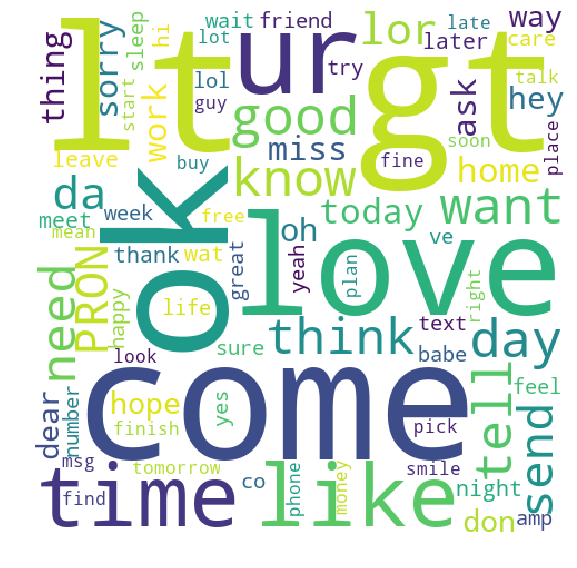

In [11]:
wordcloud_ham = WordCloud(width = 480, height = 480, 
                          background_color ='white', 
                          min_font_size = 15,
                          stopwords=stopwords,
                          random_state=3,
                          collocations=True).generate(ham_msg) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_ham) 
plt.axis("off") 
plt.tight_layout()
  
plt.show() 

In [12]:
spam = msg.loc[msg.Category=="spam"]
spam_msg = ','.join(spam.Message)

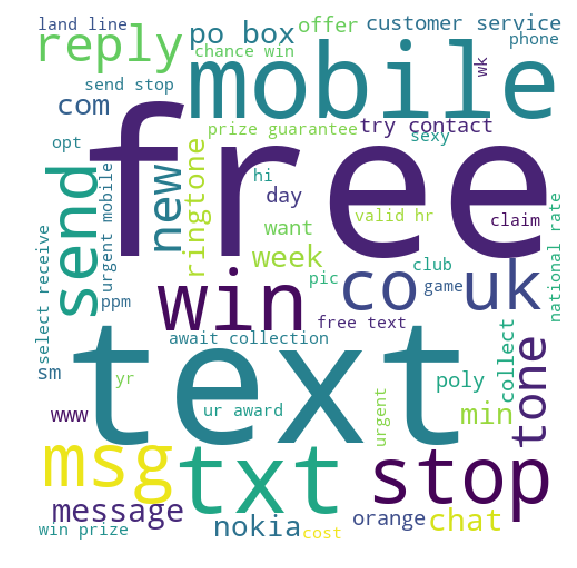

In [13]:
wordcloud_spam = WordCloud(width = 480, height = 480, 
                           background_color ='white',
                           stopwords=stopwords,
                           collocations=True,
                           random_state=1,
                           min_font_size = 15).generate(spam_msg) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8),facecolor = None) 
plt.imshow(wordcloud_spam) 
plt.axis("off") 
plt.tight_layout()

plt.show() 

In spam messages, the high frequency words are "free", "text", "call" and etc. However, in non-spam messages, there are a lot of personal words, such as "I'm", "ur", "like", "love" and etc. 

### Classification

In [14]:
# relabel the target variable to 0's and 1's
labelCode = preprocessing.LabelEncoder()
msg['Category'] = labelCode.fit_transform(msg['Category'])

In [15]:
# split data into training and testing sets

txt=msg[['Category', "Message"]]

x = txt.drop(['Category'], axis=1)
y = txt[['Category']]

kf = KFold(n_splits=10) #split into 10-fold
for train_index, test_index in kf.split(x):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

##### Vectorization

We will use the term frequency–inverse document frequency (TF-IDF) to vectorize the texts. 
<br>
- Term frequency (TF): How often a word appears in the texts. 
- Inverse document frequency (IDF): When a rarer word (such as Supercalifragilisticexpialidocious) shows up less frequently but is a good indication of the nature of the texts, IDF gives such words more weight in the vector representation.

TF-IDF is the product of TF and IDF for each token. We will use the TfidfVectorizer to achieve that by tokenizing the texts, learn the word and inverse frequency weightings, and encode new documents.

In [17]:
# use term frequency–inverse document frequency to vectorize the texts
v = TfidfVectorizer()
x_train_vect = v.fit_transform(x_train["Message"])
x_test_vect = v.fit_transform(x_test["Message"])

In [18]:
print(x_test_vect.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


To Be Continued